### What is regression spline?

* To estimate $f(x)$, most of the regression models fit the data on only one set of parameters. Regression spline is to slice the data X into small chunks and to fit each chunk into a regression model. The final solution is to put all these small building blocks together. 

* For implementation, we have a step function $$C_{i}(x) = \left\{\begin{matrix}
x & x \leq c_{i}\\ 
0 & x > c_{i}
\end{matrix}\right.$$

[referece](https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/)

The regression split is $$\hat{y} = \beta_{0} + \beta_{1}C_{1}(x_{i}) + \beta_{2}C_{2}(x_{i} ) + ...\
\beta_{k}C_{k}(x_{i})$$

### Example dataset: wage.csv

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

# read data_set
data = pd.read_csv("Wage.csv")
data.head()

,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [2]:
data.columns

Index(['ID', 'year', 'age', 'sex', 'maritl', 'race', 'education', 'region',
       'jobclass', 'health', 'health_ins', 'logwage', 'wage'],
      dtype='object')

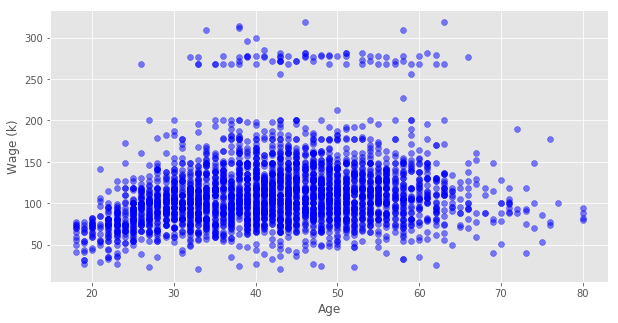

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
x = data['age']
y = data['wage']
plt.scatter(x=x, y=y, color = 'blue', alpha = .5)
plt.xlabel('Age')
plt.ylabel('Wage (k)')
plt.show()

In [4]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.33, random_state = 1)


### Use Linear regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Fitting linear regression model
x = train_x.values.reshape(-1,1)
model = LinearRegression()
model.fit(x,train_y)

# Prediction on validation dataset
valid_x = valid_x.reshape(-1,1)
pred = model.predict(valid_x)


In [18]:
print(model.coef_)
print(model.intercept_)
print('r2:', r2_score(y_pred=pred, y_true=valid_y))

[ 0.72190831]
80.6528774076
r2: 0.0338131581536


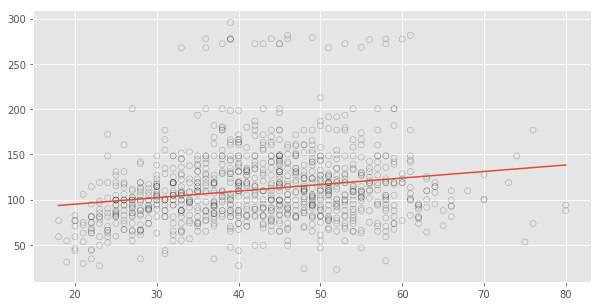

In [14]:
# Visualisation
# We will use 70 plots between minimum and maximum values of valid_x for plotting
xp = np.linspace(valid_x.min(),valid_x.max(),70)
xp = xp.reshape(-1,1)
pred_plot = model.predict(xp)

plt.rcParams['figure.figsize'] = (10, 5)

plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

We can tell from the rsquare score that linear regression is not a good model to predict the wage.

### Use polynomial regression to improbv the model

[  1.23002927e-07  -3.59879597e-05   4.19266829e-03  -2.47267765e-01
   7.67399814e+00  -1.14999926e+02   7.11719290e+02]
r2: 0.0835342283535


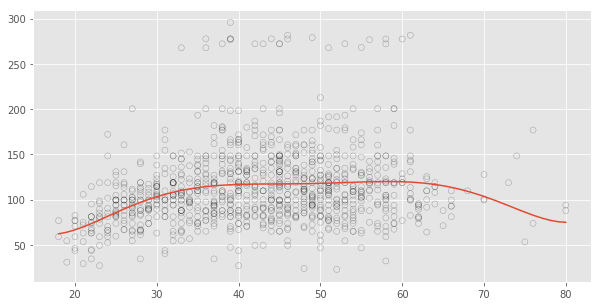

In [19]:
weights = np.polyfit(train_x, train_y, 6)
print(weights)

# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(valid_x)
print('r2:', r2_score(valid_y, pred))

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

Here we see that r-squre is improved; polynomial terms fits better on this dataset than simple linear regression.

We can try to adjust the degree value of polynomial function to fit the data.

In [22]:
for i in range(3, 9):
    print('i: ', i)
    weights = np.polyfit(train_x, train_y, i)
    model = np.poly1d(weights)
    pred = model(valid_x)
    print('r2: ', r2_score(y_pred=pred, y_true=valid_y))

i:  3
r2:  0.085857666277
i:  4
r2:  0.0836215518992
i:  5
r2:  0.0835137567847
i:  6
r2:  0.0835342283535
i:  7
r2:  0.084072395807
i:  8
r2:  0.0823630508639


Polynomial regression is known to have these issues:

* When fitting *a large number of features*, the amount of polynomial features is much bigger thus the computation is too expensive.

* It is tend to overfit.

* It is non-local. This means that if one data point in the training set changes its y value, it will greatly impact the model fit that is far away from that point.

### Regression spline

Regression spline can overcome the difficulties in the polynomial regression by splitting data into small segments so that there is no global structure imposed on the dataset. ***Step function*** is used to make the segmentation of data. The pivot point of each segment is called **knot**

In [24]:
# Dividing the data into 4 bins
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True) # retbins: whether to return the bins or not
df_cut.value_counts(sort=False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [40]:
bins

array([ 17.938,  33.5  ,  49.   ,  64.5  ,  80.   ])

In [38]:
## Concat cut the original data
df_steps = pd.concat([train_x, df_cut, train_y], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut)

## change the column name
df_steps_dummies.columns = ['17.938-33.5','33.5-49','49-64.5','64.5-80'] 
df_steps_dummies.head()


,17.938-33.5,33.5-49,49-64.5,64.5-80
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


In [77]:
# Fitting Generalised linear models
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

# Binning validation set into same 4 bins
bin_mapping = np.digitize(valid_x, bins) 

In [78]:
bin_mapping = pd.DataFrame(bin_mapping)
bin_mapping.columns = ['bins']
bin_mapping.bins = bin_mapping.bins.astype('O')

In [79]:
X_valid = pd.get_dummies(bin_mapping)
X_valid.head()

,bins_1,bins_2,bins_3,bins_4,bins_5
0,0,0,1,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [80]:
# Removing any outliers
X_valid = pd.get_dummies(bin_mapping).drop(['bins_5'], axis=1)

# Prediction
pred2 = fit3.predict(X_valid)

# Calculating RMSE
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid_y, pred2)) 
print(rms) 
#->39.9 

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping) 
pred2 = fit3.predict(X_valid_2)

39.990600783110395


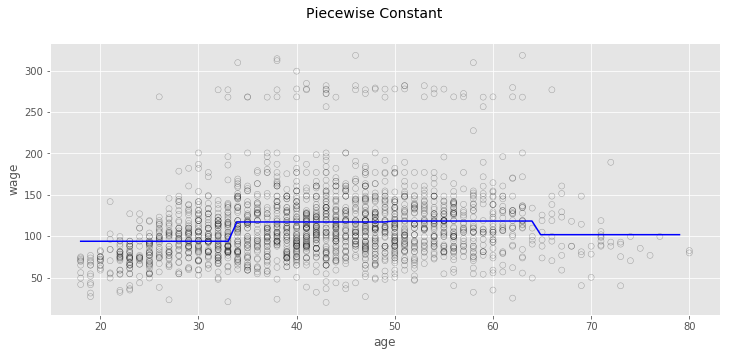

In [81]:
# Visualisation
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

This is still problematic because the overall output is not continuous. Meanwhile, the model at the first knot did not capture the increasing trend of the wage. 

To overcome this problem, we can use ***basis function*** to connect the fit in each knots. This function can capture the general shape of the data based on the fits of each bins. It is:

$$y_{i} = \beta 0 + \beta_{1} b_{1} (x_{i}) +  \beta_{2} b_{2} (x_{i}) + .. +  \beta_{k} b_{k} (x_{i})$$

A common choice of basis function is piecewise polynomial function.

### Cubic spline

a cubic spline with K knots uses cubic spline with a total of 4 + K degrees of freedom. 

In [83]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

In [91]:
#transformed_x.head()

In [92]:
# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree =3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

39.40318768341125
39.34292609147627


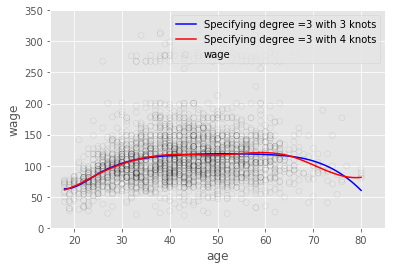

In [94]:
# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65),degree =3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))

# Calculating RMSE values
rms1 = sqrt(mean_squared_error(valid_y, pred1))
print(rms1)
#-> 39.4
rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)
#-> 39.3

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots', color = 'b')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

Here we can see that the boundary of the regression line seems erratic. To solve this problem, we can use natural cubic splines. It adds more conditional constraints on the boundary of the data.

39.44823813743623


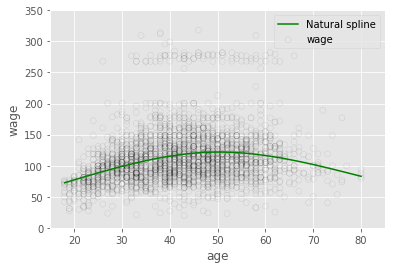

In [96]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.GLM(train_y, transformed_x3).fit()

# Prediction on validation set
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Natural spline')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

In [97]:
## calcula
print('r2:', r2_score(y_pred=pred, y_true=valid_y))

r2: 0.0823630508639


### Comparison

* Unlike polynomials, which must use a high degree polynomial to produce flexible fits, splines introduce flexibility by increasing the number of knots but keep the degree fixed.

* Spline produces more stable estimates. 

* Splines also allow us to place more knots, and hence flexibility, over regions where the function seems to be changing rapidly, and fewer knots where the function appears more stable. The extra flexibility in the polynomial produces undesirable results at the boundaries, whereas the natural cubic spline still provides a reasonable fit to the data.

